# Classification. Linear models and KNN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
from math import log
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-(X@weights.T)))

    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        samples = x.shape[0]
        sum_log = 0

        for i in range (len(x)):
            x_, y_ = x[i], y[i]
            sum_log += log(1 + np.exp(-(x_ @ weights.T * y_)))

        return sum_log / samples + 1 / (2 * self.C) * np.linalg.norm(weights)
     
    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features, samples = X_ext.shape[1], X_ext.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        iter_count = self.max_iter
        for i in range(self.max_iter):

            iter_count -= 1
            wt = self.weights_.copy()
            grad_sum = 0

            for q in range (len(X_ext)):
                x_, y_ = X_ext[q], y[q]
                grad_sum += y_ * x_ * (1 - (1 / (1 + np.exp(-(x_ @ self.weights_.T * y_)))))

            delta = grad_sum / samples - 1 / self.C * wt**2
            self.weights_ -= self.eta * -delta

            self.loss.append(self.get_loss(X_ext,wt,y))

            if np.linalg.norm((self.weights_ - wt)) < self.tol or iter_count == 0:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_pred = 1 / (1 + np.exp(-(X@self.weights_.T[1:])))
        y_pred[y_pred < 0.5] = -1
        y_pred[y_pred >= 0.5] = 1
        return y_pred

In [6]:
from sklearn import datasets
from sklearn import metrics

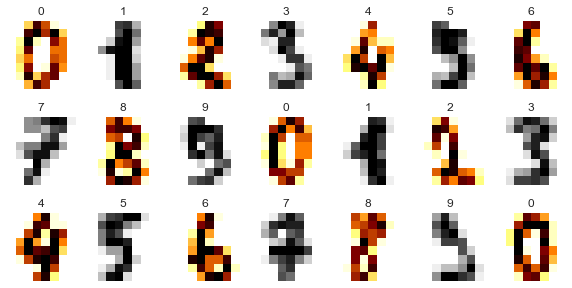

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

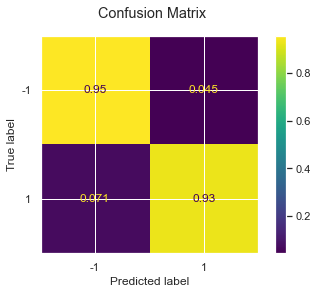

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9151009046624913, 0.9416666666666667)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

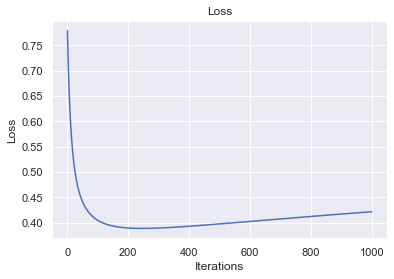

In [18]:
## your code
sns.lineplot(x=np.arange(len(model.loss)),y=model.loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss');

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [19]:
## your code
etas = []
eta = [0.0001, 0.001, 0.01, 0.1]
for et in eta:
    model = CustomLogisticRegression(eta=et)
    model.fit(X_train, y_train)
    etas.append(model.loss)

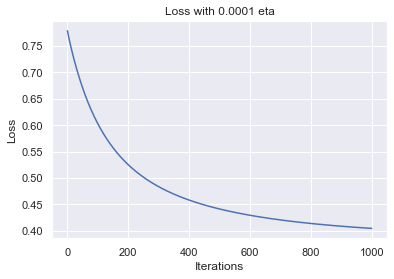

In [20]:
sns.lineplot(x=np.arange(len(etas[0])),y=etas[0])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Loss with {eta[0]} eta');

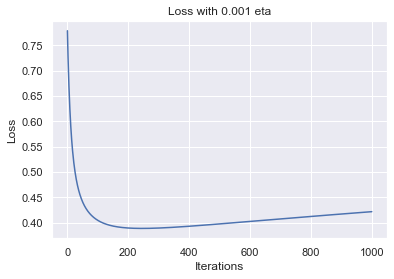

In [21]:
sns.lineplot(x=np.arange(len(etas[1])),y=etas[1])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Loss with {eta[1]} eta');

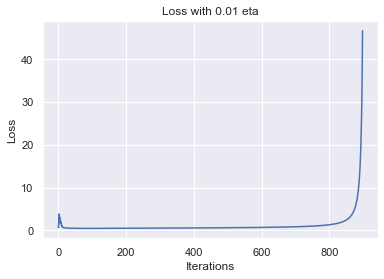

In [22]:
sns.lineplot(x=np.arange(len(etas[2])),y=etas[2])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Loss with {eta[2]} eta');

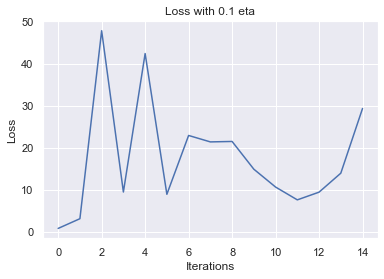

In [23]:
sns.lineplot(x=np.arange(len(etas[3])),y=etas[3])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Loss with {eta[3]} eta');

In [24]:
etas[3][10:20]

[10.618124833320522,
 7.5708648484277745,
 9.401990195226826,
 13.912154281676504,
 29.29985269894817,
 inf,
 inf,
 inf,
 inf,
 inf]

< your thoughts >
**При увеличении eta свыше 0.001, loss в определенный момент просто взлетает, т.к. большой лёрнинг рейт не дает эффективно находить глобальные минимумы**
**Сходимость в данном случае нарушена, при eta 0.1 уже после 15 итерации лосс улетает в бесконечность космоса)**

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [25]:
## your code
train_score, test_score = [], []
c_val = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5]

for i in c_val:
    model = CustomLogisticRegression(C=i)
    model.fit(X_train, y_train)

    train_score.append(metrics.accuracy_score(y_train, model.predict(X_train)))

    test_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

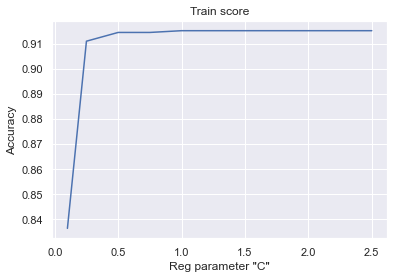

In [26]:
sns.lineplot(x=c_val,y=train_score)
plt.xlabel('Reg parameter "C"')
plt.ylabel('Accuracy')
plt.title('Train score');

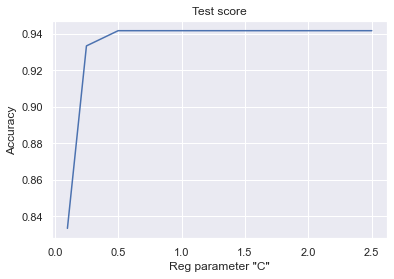

In [27]:
sns.lineplot(x=c_val,y=test_score)
plt.xlabel('Reg parameter "C"')
plt.ylabel('Accuracy')
plt.title('Test score');

< your thoughts >
**При ослаблении регуляризации Accuracy увеличивается, что для нашего сбалансированного датасета есть хорошо**

**(0.5 points)** Compare zero initialization and random initialization. 

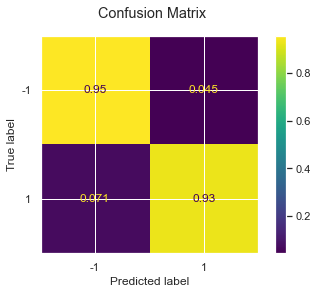

In [28]:
## your code
model_zero_init = CustomLogisticRegression(zero_init=True)
train_acc_zero_init, test_acc_zero_init = fit_evaluate(model_zero_init, X_train, y_train, X_test, y_test)

In [29]:
train_acc_zero_init, test_acc_zero_init

(0.9157967988865693, 0.9416666666666667)

< your thoughts >
**Сравнивая результаты с рандомной инициализацией (0.9151009046624913, 0.9416666666666667), видно, что практически ничего не изменилось. Confusion Matrix абсолютно такая же**

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [30]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [31]:
# model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
# knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
# assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]),
#                                                 np.array([[0.5, 0.5], [1, 0]])),
#                    np.array([[0.70710678, 1.41421356],
#                              [0.70710678, 1.        ]]))

In [33]:
# model.classes_ = ['one', 'two', 'three']
# assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])),
#                    np.array([2,4,0]))

In [34]:
# X, y = datasets.load_digits(n_class=10, return_X_y=True)
#
# _, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
# for ax, image, label in zip(axes.flatten(), X, y):
#     ax.set_axis_off()
#     ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
#     ax.set_title(label)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [35]:
# model.fit(X_train, y_train)
# knn.fit(X_train, list(map(str, y_train)));

In [36]:
# assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [37]:
# train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [38]:
# assert train_acc == 1
# assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [39]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [40]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [41]:
np.random.seed(42)
data = pd.read_csv('train.csv').set_index('PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [43]:
## your code
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

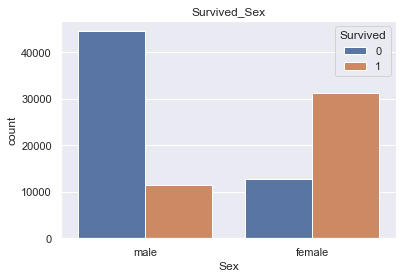

In [44]:
sns.countplot(x="Sex", data=data, hue='Survived')
plt.title('Survived_Sex');


< your thoughts >
**Как обычно, мужчины умирали намного чаще**

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [45]:
## your code
age = data.copy()
bins = [0, 5, 12, 18, 24, 35, 60, 120]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
age['AgeGroup'] = pd.cut(age["Age"], bins, labels = labels)

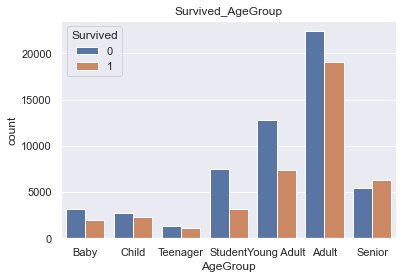

In [46]:
sns.countplot('AgeGroup', data = age, hue = "Survived")
plt.title('Survived_AgeGroup');

In [47]:
pd.crosstab( [age.Survived], [age.AgeGroup], margins = True)
# Всего значений 96708, т.к. NaN'ы есть

AgeGroup,Baby,Child,Teenager,Student,Young Adult,Adult,Senior,All
Survived,,,,,,,,
0,3132,2693,1360,7532,12748,22417,5408,55290
1,1999,2331,1118,3205,7383,19119,6263,41418
All,5131,5024,2478,10737,20131,41536,11671,96708


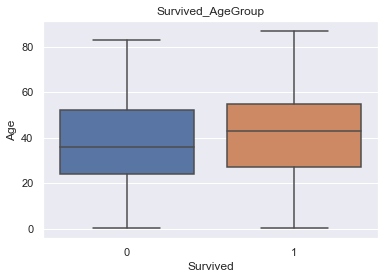

In [48]:
sns.boxplot(y = 'Age', data = age, x = "Survived")
plt.title('Survived_AgeGroup');

In [49]:
print(f"Среднее выживших: {np.mean(data[data['Survived'] == 1].Age)}")
print(f"Среднее невыживших: {np.mean(data[data['Survived'] == 0].Age)}")

print(f"Медиана выживших: {np.nanmedian(data[data['Survived'] == 1].Age)}")
print(f"Медиана невыживших: {np.nanmedian(data[data['Survived'] == 0].Age)}")

Среднее выживших: 40.55379931430776
Среднее невыживших: 36.708694881533724
Медиана выживших: 43.0
Медиана невыживших: 36.0


< your thoughts >
**В отличие от несинтетического Титаника, здесь, наоборот, выживает больший процент стариков, чем детей. Да и возраст средний куда выше**

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

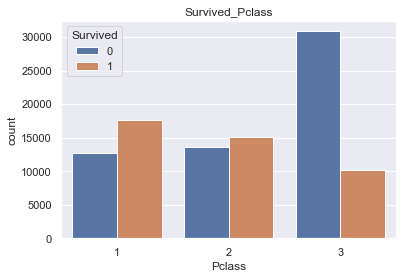

In [50]:
## your code
sns.countplot(x="Pclass", data=data, hue='Survived')
plt.title('Survived_Pclass');

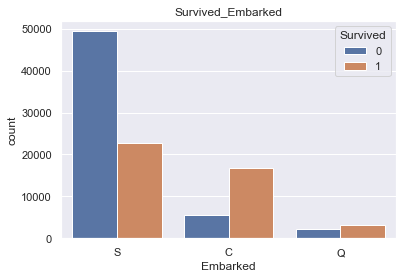

In [51]:
sns.countplot(x="Embarked", data=data, hue='Survived')
plt.title('Survived_Embarked');

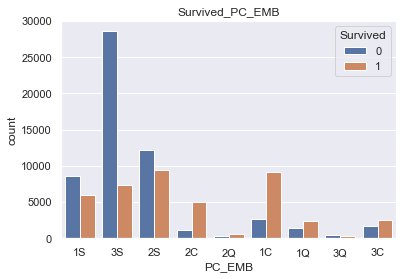

In [52]:
data['PC_EMB'] = data["Pclass"].astype(str) + data["Embarked"]
sns.countplot(x="PC_EMB", data=data, hue='Survived')
plt.title('Survived_PC_EMB');

< your thoughts >
**Самый безопасный класс почему-то второй, самый "лучший" порт - C**
**Но на самое безопасное сочетание может претендовать и 1ый класс + порт С**

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [53]:
## your code
print("Total number of rows in data: ", len(data))
nas= data.columns[data.isna().any()]
print("NA values in dataset:")
for col in nas:
    print(col,sum(data.loc[:,col].isna()),",",round(sum(data.loc[:,col].isna())/len(data)*100,2),"% of data")

Total number of rows in data:  100000
NA values in dataset:
Age 3292 , 3.29 % of data
Ticket 4623 , 4.62 % of data
Fare 134 , 0.13 % of data
Cabin 67866 , 67.87 % of data
Embarked 250 , 0.25 % of data
PC_EMB 250 , 0.25 % of data


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >
**Судя по распределению:**
 - Age можно заменить медианой
 - Ticket бесполезная нам колонка
 - Fare можно заменить медианой, т.к. большая дисперсия у переменной, опасно заменять средним
 - Cabin бесполезная нам колонка
 - Embarked и PClass я, пожалуй, дропну и оставлю только PC_EMB, сделаю под них отдельный класс

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [54]:
## your code
test_data = pd.read_csv('test.csv').set_index('PassengerId')
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [55]:
datasets = [data, test_data]
for dataset in datasets:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    dataset['PC_EMB'] = dataset["Pclass"].astype(str) + dataset["Embarked"]
    dataset['PC_EMB'].fillna('None', inplace=True)
    dataset.drop(["Pclass", "Embarked", 'Ticket', 'Cabin'], axis=1, inplace=True)

In [56]:
import re
genders = {"male": 0, "female": 1}
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in datasets:
    dataset['Sex'] = dataset['Sex'].map(genders)

    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                             'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    dataset['Title'] = dataset['Title'].map(titles)

    dataset['Title'] = dataset['Title'].fillna(0)

    dataset.drop(["Name"], axis=1, inplace=True)

In [57]:
p_embs = {"1C": 1, "1Q": 2, "1S": 3, "2C": 4, "2Q": 5, "2S": 6, "3C": 7, "3Q": 8, "3S": 9, "None": 10}

for dataset in datasets:
    dataset['PC_EMB'] = dataset['PC_EMB'].map(p_embs)

In [58]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100000 to 199999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     100000 non-null  int64  
 1   Age     100000 non-null  float64
 2   SibSp   100000 non-null  int64  
 3   Parch   100000 non-null  int64  
 4   Fare    100000 non-null  float64
 5   PC_EMB  100000 non-null  int64  
 6   Title   100000 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 6.1 MB


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Sex       100000 non-null  int64  
 2   Age       100000 non-null  float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      100000 non-null  float64
 6   PC_EMB    100000 non-null  int64  
 7   Title     100000 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 8.9 MB


In [60]:
y = data['Survived']
data.drop(['Survived'], axis=1, inplace=True)

In [61]:
scaler = StandardScaler().fit(data)
data_scaled = scaler.transform(data)
test_data_scaled = scaler.transform(test_data)

In [62]:
logreg = LogisticRegression()
logreg.fit(data_scaled, y)

y_pred = logreg.predict(test_data_scaled)

acc_log = round(logreg.score(data_scaled, y) * 100, 2)
acc_log

75.96

In [63]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(data_scaled, y)

y_pred_knn = knn.predict(test_data_scaled)

acc_knn = round(knn.score(data_scaled, y) * 100, 2)
acc_knn

99.27

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, data_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.7581  0.76275 0.76035 0.75775 0.75935]
Mean: 0.75966


In [65]:
scores = cross_val_score(knn, data_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.71945 0.7172  0.71975 0.71755 0.718  ]
Mean: 0.7183900000000001


In [66]:
## your code
for dataset in datasets:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)


In [67]:
scaler2 = StandardScaler().fit(data)
data_scaled = scaler2.transform(data)
test_data_scaled = scaler2.transform(test_data)

In [68]:
logreg2 = LogisticRegression(solver='lbfgs', penalty='l2', C=0.1)
logreg2.fit(data_scaled, y)

y_pred2 = logreg2.predict(test_data_scaled)

acc_log = round(logreg2.score(data_scaled, y) * 100, 2)
acc_log

76.13

In [69]:
knn2 = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_jobs=-1, n_neighbors=19, p=1, weights='uniform')
knn2.fit(data_scaled, y)

y_pred_knn2 = knn2.predict(test_data_scaled)

acc_knn = round(knn2.score(data_scaled, y) * 100, 2)
acc_knn

77.04

In [70]:
scores = cross_val_score(logreg2, data_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.7615 0.7629 0.7618 0.7594 0.7602]
Mean: 0.76116


In [71]:
scores = cross_val_score(knn2, data_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.76115 0.76285 0.76555 0.7637  0.76665]
Mean: 0.7639800000000001


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [72]:
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": y_pred2
})

submission.to_csv('submission.csv', index=False) # score 0.78840

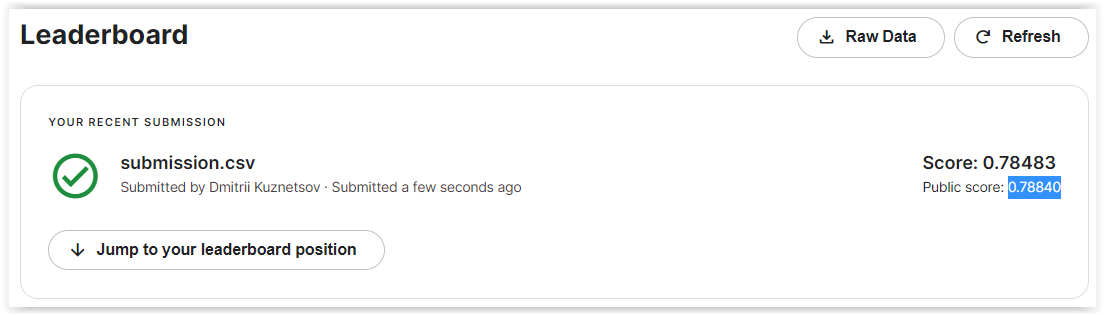

In [73]:
from IPython.display import Image
Image("score.png")

In [74]:
submission2 = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": y_pred_knn2
})

submission2.to_csv('submission2.csv', index=False) # score 0.75829 (((

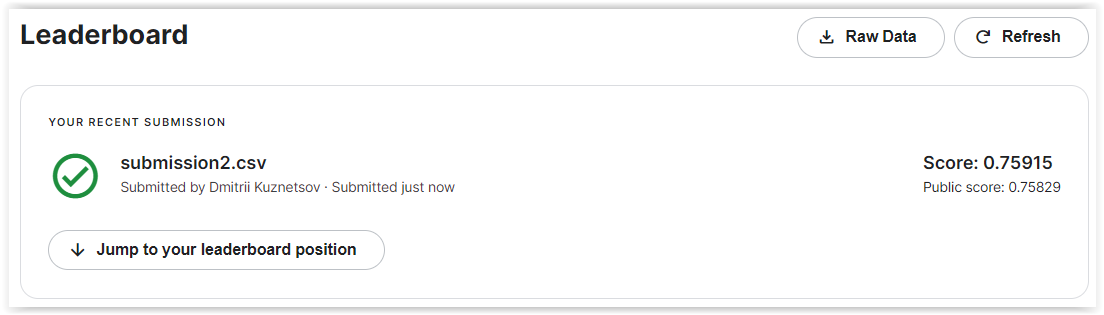

In [75]:
from IPython.display import Image
Image("score2.png")

In [76]:
from sklearn.model_selection import GridSearchCV
parametrs = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': np.linspace(0.05, 1, 10), 'fit_intercept': ['True', 'False'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

logreg3 = LogisticRegression()
search = GridSearchCV(logreg3, parametrs)
search.fit(data_scaled, y)
search.best_params_

{'C': 0.05, 'fit_intercept': 'True', 'penalty': 'l2', 'solver': 'liblinear'}

In [77]:
logreg3 = LogisticRegression(solver='liblinear', penalty='l2', C=0.05)
logreg3.fit(data_scaled, y)

y_pred3 = logreg3.predict(test_data_scaled)

acc_log = round(logreg3.score(data_scaled, y) * 100, 2)
acc_log

76.13

In [78]:
submission3 = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": y_pred3
})

submission3.to_csv('submission3.csv', index=False) # score 0.78840 снова (((

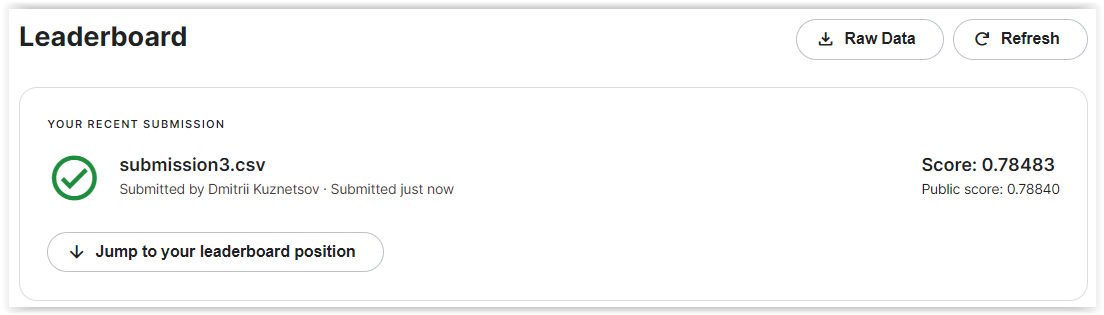

In [79]:
from IPython.display import Image
Image("score3.png")